In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import pickle as pic
from matplotlib.backends.backend_pdf import PdfPages
import time
start_time = time.time()

In [2]:
class Node:
    
    def __init__(self, char_list, num_states, parent=None, left=None, right=None):
        # num_states includes the 0 state. For example, if the possible states are 0 or 1, then num_states=2
        self.chars = char_list
        self.parent = parent
        self.left = left
        self.right = right
        self.num_chars = len(self.chars)
        self.num_states = num_states
        
    def is_leaf(self):
        return not (self.left or self.right)

    def duplicate(self, p, q=None, dropout_rate=0):
        assert len(p) == len(self.chars), "invalid p vector"
        if q:
            for i in range(len(p)):
                assert len(q[i]) + 1 == self.num_states, "invalid q[" + str(i) + "] vector"
                
        new_chars = []
        if not q:
            q = [None for i in self.chars]

        for l in range(len(self.chars)):
            if self.chars[l] != 0:
                new_chars.append(self.chars[l])
            else:
                if np.random.random() < p[l]:
                    new_chars.append(np.random.choice(np.arange(1, self.num_states), 1, p=q[l])[0])
                else:
                    new_chars.append(self.chars[l])
        
        return Node(new_chars, self.num_states)
    
    def __str__(self):
        s = ''
        for x in self.chars:
            s += str(x) + '|'
        return s[:-1]
                    
                    
def simulation(p, num_states, time, q=None):
    root = Node([0 for i in p], num_states)
    curr_gen = [root]
    for t in range(time):
        new_gen = []
        for n in curr_gen:
            c1 = n.duplicate(p, q)
            c2 = n.duplicate(p, q)
            c1.parent = n
            c2.parent = n
            n.left = c1
            n.right = c2
            new_gen.append(c1)
            new_gen.append(c2)
        curr_gen = new_gen
    return curr_gen

def find_lineage(node):
    lineage = [node]
    while node.parent:
        node = node.parent
        lineage.insert(0, node)
    return lineage

def find_root(samples):
    return find_lineage(samples[0])[0]

def print_tree(root):
    
    def tree_str(node, level=0):
        ret = "\t"*level+str(node)+"\n"
        if node.left:
            ret += tree_str(node.left, level+1)
        if node.right:
            ret += tree_str(node.right, level+1)
        return ret
    
    print(tree_str(root))
    


In [3]:
def generate_frequency_matrix(samples, subset=None):
    k = samples[0].num_chars
    m = samples[0].num_states + 1
    F = np.zeros((k,m), dtype=int)
    if not subset:
        subset = list(range(len(samples)))
    for i in subset:
        for j in range(k):
            F[j][samples[i].chars[j]] += 1
    return F
            
def split_data(F):
    k,m = F.shape[0], F.shape[1]
    split_data = []
    for i in range(k):
        for j in range(1, m-1):
            split_data.append((i,j))
    split_data.sort(key=lambda tup: F[tup[0]][tup[1]], reverse=True)
    index = 0
    
    for i in range(5):
        s = ''
        for j in range(1, 5):
            a, b = split_data[index][0], split_data[index][1]
            s += str((a,b)) + " freq =" + str(F[a][b]) + " "
            index += 1
        print(s)
            
    
def construct_connectivity_graph(samples, subset=None):
    n = len(samples)
    k = samples[0].num_chars
    m = samples[0].num_states
    G = nx.Graph()
    if not subset:
        subset = range(n)
    for i in subset:
        G.add_node(i)
    F = generate_frequency_matrix(samples, subset)
    for i in subset:
        for j in subset:
            if j <= i:
                continue
            n1 = samples[i]
            n2 = samples[j]
            #compute simularity score
            score = 0
            for l in range(k):
                x = n1.chars[l]
                y = n2.chars[l]
                if min(x, y) >= 0 and max(x,y) > 0:
                    if x==y:
                        score -= 3*(len(subset) - F[l][x] - F[l][-1])
                    elif min(x,y) == 0:
                        score += F[l][max(x,y)] - 1
                    else:
                        score += (F[l][x] + F[l][y]) - 2
                        
                if score != 0:
                    G.add_edge(i,j, weight=score)
    return G


In [4]:
def max_cut_heuristic(G, sdimension, iterations, show_steps=False):
    #n = len(G.nodes())
    d = sdimension+1
    emb = {}        
    for i in G.nodes():
        x = np.random.normal(size=d)
        x = x/np.linalg.norm(x)
        emb[i] = x
        
    def show_relaxed_objective():
        score = 0
        for e in G.edges():
            u = e[0]
            v = e[1]
            score += G[u][v]['weight']*np.linalg.norm(emb[u]-emb[v])
        print(score)
        
    for k in range(iterations):
        new_emb = {}
        for i in G.nodes:
            cm = np.zeros(d, dtype=float)
            for j in G.neighbors(i):
                cm -= G[i][j]['weight']*np.linalg.norm(emb[i]-emb[j])*emb[j]
            cm = cm/np.linalg.norm(cm)
            new_emb[i] = cm
        emb = new_emb
        
    #print("final relaxed objective:")
    #show_relaxed_objective()
    return_set = set()
    best_score = 0
    for k in range(3*d):
        b = np.random.normal(size=d)
        b = b/np.linalg.norm(b)
        S = set()
        for i in G.nodes():
            if np.dot(emb[i], b) > 0:
                S.add(i)
        this_score = evaluate_cut(S, G)
        if this_score > best_score:
            return_set = S
            best_score = this_score
    #print("score before hill climb = ", best_score)
    improved_S = improve_cut(G, return_set)
    #final_score = evaluate_cut(improved_S, G)
    #print("final score = ", final_score)
    return improved_S

def improve_cut(G, S):
    #n = len(G.nodes())
    ip = {}
    new_S = S.copy()
    for i in G.nodes():
        improvement_potential = 0
        for j in G.neighbors(i):
            if cut(i,j,new_S):
                improvement_potential -= G[i][j]['weight']
            else:
                improvement_potential += G[i][j]['weight']
        ip[i] = improvement_potential
        
    all_neg = False
    iters = 0
    while (not all_neg) and (iters < 2*len(G.nodes)):
        best_potential = 0
        best_index = 0
        for i in G.nodes():
            if ip[i] > best_potential:
                best_potential = ip[i]
                best_index = i
        if best_potential > 0:
            for j in G.neighbors(best_index):
                if cut(best_index,j,new_S):
                    ip[j] += 2*G[best_index][j]['weight']
                else:
                    ip[j] -= 2*G[best_index][j]['weight']
            ip[best_index] = -ip[best_index]
            if best_index in new_S:
                new_S.remove(best_index)
            else:
                new_S.add(best_index)
        else:
            all_neg = True
        iters += 1
    #print("number of hill climbing interations: ", iters)
    return new_S


In [5]:
def evaluate_cut(S, G, B=None, show_total=False):
    cut_score = 0
    total_good = 0
    total_bad = 0
    for e in G.edges():
        u = e[0]
        v = e[1]
        w_uv = G[u][v]['weight']
        total_good += float(w_uv)
        if cut(u,v,S):
            cut_score += float(w_uv)

    if B:
        for e in B.edges():
            u = e[0]
            v = e[1]
            w_uv = B[u][v]['weight']
            total_bad += float(w_uv)
            if cut(u,v,S):
                cut_score -= float(w_uv)
            
    if show_total:
        print("total good = ", total_good)
        print("total bad = ", total_bad)
    return(cut_score)

def greedy_cut(samples, subset=None):
    F = generate_frequency_matrix(samples, subset)
    k,m = F.shape[0], F.shape[1]
    freq = 0
    char = 0
    state = 0
    if not subset:
        subset = list(range(len(samples)))
    for i in range(k):
        for j in range(1, m-1):
            if F[i][j] > freq and F[i][j] < len(subset) - F[i][-1] :
                char, state = i,j
                freq = F[i][j]
    if freq == 0:
        return random_nontrivial_cut(subset)
    S = set()
    Sc = set()
    missing = set()
    #print(char, state)
    for i in subset:
        if samples[i].chars[char] == state:
            S.add(i)
        elif samples[i].chars[char] == -1:
            missing.add(i)
        else:
            Sc.add(i)
            
    if not Sc:
        if len(S) == len(subset) or len(S) == 0:
            print(F)
            print(char, state, len(subset))
        return S
    
    for i in missing:
        s_score = 0
        sc_score = 0
        for j in S:
            for l in range(k):
                if samples[i].chars[l] > 0 and samples[i].chars[l] == samples[j].chars[l]:
                    s_score += 1
        for j in Sc:
            for l in range(k):
                if samples[i].chars[l] > 0  and samples[i].chars[l] == samples[j].chars[l]:
                    sc_score += 1
        if s_score/len(S) > sc_score/len(Sc):
            S.add(i)
        else:
            Sc.add(i)
        
    if len(S) == len(subset) or len(S) == 0:
            print(F)
            print(char, state, len(subset))
    return S
    
def random_cut(subset):
    S = set()
    for i in subset:
        if np.random.random() > 0.5:
            S.add(i)
    return S

def random_nontrivial_cut(subset):
    assert len(subset) > 1
    S = set()
    lst = list(subset)
    S.add(lst[0])
    for i in range(2,len(lst)):
        if np.random.random() > 0.5:
            S.add(lst[i])
    return S


def cut(u, v, S):
    return ((u in S) and (not v in S)) or ((v in S) and (not u in S))

            
def num_incorrect(S, h):
    num = 0
    for i in range(int(2**h/2)):
        if not i in S:
            num += 1

    for i in range(int(2**h/2), 2**h):
        if i in S:
            num += 1

    return min(num, 2**h - num)

In [6]:
class Experiment:
    
    def __init__(self, p, num_states, time, q=None, dropout_rate=0):
        self.p = p
        self.num_states = num_states
        self.q = q
        self.time = time
        self.samples = simulation(p, num_states, time, q)
        if dropout_rate:
            for n in self.samples:
                for i in range(len(n.chars)):
                    if np.random.random() < dropout_rate:
                        n.chars[i] = -1
        self.num_samples = len(self.samples)
        self.root = find_root(self.samples)        
        T = nx.DiGraph()
        node_map = {self.samples[i]:i for i in range(self.num_samples)}
        for i in range(self.num_samples):
            T.add_node(i)
        def build_gt_tree(n):
            if n.is_leaf():
                return node_map[n]
            root_label = len(T.nodes())
            T.add_node(root_label)
            if n.left:
                left_label = build_gt_tree(n.left)
                T.add_edge(root_label, left_label)
            if n.right:
                right_label = build_gt_tree(n.right)
                T.add_edge(root_label, right_label)
            return root_label
        build_gt_tree(self.root)
        self.ground_truth_tree = T
      
        
    def build_tree(self, method='greedy', subset=None, sim_thresh=0):
        if not subset:
            subset = list(range(len(self.samples)))
        else:
            subset = list(subset)
        subset = remove_duplicates(self.samples, subset)
        T = nx.DiGraph()
        for i in subset:
            T.add_node(i)
        def build_helper(S):
            assert S, "error, S = "+ str(S)
            if len(S) == 1:
                return list(S)[0]
            left_set = set()
            if method == 'greedy':
                left_set = greedy_cut(self.samples, subset=S)
            elif method == 'SDP':
                G = construct_connectivity_graph(self.samples, subset=S)
                left_set = max_cut_heuristic(G, 3, 50)
            elif method == 'greedy+':
                G = construct_connectivity_graph(self.samples, subset=S)
                left_set = greedy_cut(self.samples, subset=S)
                left_set = improve_cut(G,left_set)
            elif method == 'spectral':
                G = construct_similarity_graph(self.samples, subset=list(S), threshold=sim_thresh)
                left_set = spectral_split(G)
                left_set = spectral_improve_cut(left_set, G)
            elif method == 'sgreedy+':
                G = construct_similarity_graph(self.samples, subset=S, threshold=sim_thresh)
                left_set = spectral_improve_cut(greedy_cut(self.samples, subset=S) , G)
                
            if len(left_set) == 0 or len(left_set) == len(S):
                left_set = greedy_cut(self.samples, subset=S)
            right_set = set()
            for i in S:
                if not i in set(left_set):
                    right_set.add(i)
            root = len(T.nodes) - len(subset) + len(self.samples)
            T.add_node(root)
            left_child = build_helper(left_set)
            right_child = build_helper(right_set)
            T.add_edge(root, left_child)
            T.add_edge(root, right_child)
            return root
        build_helper(subset)
        return T
        
    def triplets_correct(self, T, sample_size=1000):
        TC = 0
        sample_set = np.array([v for v in T.nodes() if T.in_degree(v) == 1 and T.out_degree(v) == 0])
        Tt = self.ground_truth_tree
        
        for a in range(sample_size):
            chosen = np.random.choice(sample_set, 3, replace=False)
            if outgroup(chosen[0], chosen[1], chosen[2], T) == outgroup(chosen[0], chosen[1], chosen[2], Tt):
                TC += 1
        return TC/sample_size
    
    def triplets_correct_at_depth(self, T, method='aggregate', sample_size=1000, sampling_depths=None):
        sample_set = set([v for v in T.nodes() if T.in_degree(v) == 1 and T.out_degree(v) == 0])
        Tt = self.ground_truth_tree
        children = {}
        num_triplets = {}
        nodes_at_depth = [[] for i in range(2*int(np.log2(len(sample_set))))]
        def find_children(node, depth):
            children[node] = []
            if Tt.out_degree(node) == 0:
                if node in sample_set:
                    children[node].append(node)
                return
            for n in Tt.neighbors(node):
                find_children(n, depth+1)
                children[node] += children[n]
            L, R = list(Tt.neighbors(node))[0], list(Tt.neighbors(node))[1]
            num_triplets[node] = len(children[L])*nCr(len(children[R]), 2) + len(children[R])*nCr(len(children[L]), 2)
            if num_triplets[node] > 0:
                nodes_at_depth[depth].append(node)
        
        find_children(len(self.samples), 0)
        
        def sample_at_depth(d):
            denom = sum([num_triplets[v] for v in nodes_at_depth[d]])
            node = np.random.choice(nodes_at_depth[d], 1, [num_triplets[v]/denom for v in nodes_at_depth[d]])[0]
            L, R = list(Tt.neighbors(node))[0], list(Tt.neighbors(node))[1]
            if np.random.random() < (len(children[R])-1)/(len(children[R])+len(children[L])-2):
                outgrp = np.random.choice(children[L], 1)[0]
                ingrp = np.random.choice(children[R], 2, replace=False)
            else:
                outgrp = np.random.choice(children[R], 1)[0]
                ingrp = np.random.choice(children[L], 2, replace=False)
            return outgroup(ingrp[0], ingrp[1], outgrp, T) == outgrp
        
        if not sampling_depths:
                sampling_depths = [d for d in range(len(nodes_at_depth)) if nodes_at_depth[d]]
        if method == 'aggregate':
            score = 0
            for d in sampling_depths:
                for a in range(sample_size):
                    score += int(sample_at_depth(d))
            return score/(sample_size*len(sampling_depths))
        elif method == 'geometric':
            score = 0
            for a in range(sample_size):
                w_list = [1/(sampling_depths[-1]-x+1) for i in sampling_depths]
                d = np.random.choice(sampling_depths, 1, [w/sum(w_list) for w in w_list])[0]
                score += int(sample_at_depth(d))
            return score /sample_size
        elif method == 'all':
            ret = []
            for d in sampling_depths:
                score = 0
                for a in range(sample_size):
                    score += int(sample_at_depth(d))
                ret.append(score/sample_size)
            return np.array(ret)
            
        
            
                
                    
                
        
    
            
    
  

In [246]:
h = 10
E = Experiment([0.1 for i in range(10)], 11, h)
subsample = []
for i in range(2**h):
    if np.random.random() < 0.2:
        subsample.append(i)
T = E.build_tree('greedy', subset=subsample)
print(E. triplets_correct_at_depth(T, method='all'))
print('\n')
E. triplets_correct_at_depth(E.ground_truth_tree, method='all')

[0.942 0.751 0.669 0.768 0.705 0.748 0.706 0.639 0.727]




array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [193]:
A = [1,2]
B = [3,4]
print(A+B)
print(A)
print(B)
int(0)
A.append(1)

[1, 2, 3, 4]
[1, 2]
[3, 4]


In [195]:
ret = []
score = 0
ret.append(score)

In [8]:
def find_tree_lineage(i, T):
    p = list(T.predecessors(i))
    curr_node = i
    ancestor_list = [curr_node]
    while p:
        curr_node = p[0]
        ancestor_list.insert(0, curr_node)
        p = list(T.predecessors(curr_node))
    return(ancestor_list)

        
def outgroup(i, j, k, T):
    assert i != j and i != k and j != k, str(i) + ' ' + str(j) + ' ' + str(k) + ' not distinct'
    
    Li = find_tree_lineage(i, T)
    Lj = find_tree_lineage(j, T)
    Lk = find_tree_lineage(k, T)
    l = 0
    while Li[l] == Lj[l] and Lj[l] == Lk[l]:
        l += 1
    if Li[l] != Lj[l] and Li[l] != Lk[l] and Lj[l] != Lk[l]:
        return None
    if Li[l] == Lj[l]:
        return k
    if Li[l] == Lk[l]:
        return j
    if Lj[l] == Lk[l]:
        return i
    
    
    
def evaluate_split(S, subset, T, sample_size=1000):
    # assume S \subseteq T.leaves
    def S_outgroup(i,j,k):
        if (not cut(i,j,subset)) and (not cut(j,k,subset)):
            return None
        if not cut(i,j,subset):
            return k
        if not cut(i,k,subset):
            return j
        return i
    
    TC = 0
    TI = 0
    unresolved = 0
    superset = np.array(list(S))
    num_sampled = 0
    for a in range(sample_size):
        chosen = np.random.choice(superset, 3, replace=False)
        oS = S_outgroup(chosen[0], chosen[1], chosen[2])
        oT = outgroup(chosen[0], chosen[1], chosen[2], T)
        if oS == None or oT == None:
            unresolved += 1
        else:
            if oS == oT:
                TC += 1
            else:
                TI += 1
    return TC/sample_size, TI/sample_size, unresolved/sample_size
        
                    
def remove_duplicates(nodes, indices):
    indices = list(indices)
    indices.sort(key=lambda i: nodes[i].chars)
    final_set = set()
    i = 0
    j = 1
    while j < len(indices):
        if nodes[indices[i]].chars != nodes[indices[j]].chars:
            final_set.add(indices[i])
            i = j
        j += 1
    final_set.add(indices[i])
    return final_set
            
def mult_chain(a,b):
    f = 1
    for i in range(a, b+1):
        f*=i
    return f

def nCr(n, k):
    if k > n:
        return 0
    if k > n/2:
        return nCr(n, n-k)
    return int(mult_chain(n-k+1,n)/mult_chain(1,k))


In [9]:
def similarity(u, v, samples):
    k = samples[0].num_chars
    return sum([1 for i in range(k) if samples[u].chars[i] == samples[v].chars[i] and samples[u].chars[i] > 0])

def construct_similarity_graph(samples, subset=None, threshold=0):
    G = nx.Graph()
    if not subset:
        subset = range(len(samples))
    for i in subset:
        G.add_node(i)
    F = generate_frequency_matrix(samples, subset)
    k,m = F.shape[0], F.shape[1]
    for i in range(k):
        for j in range(1,m-1):
            if F[i][j] == len(subset) - F[i][-1]:
                threshold += 1
    for i in subset:
        for j in subset:
            if j <= i:
                continue
            s = similarity(i,j, samples) 
            if s > threshold:
                G.add_edge(i,j, weight=(s-threshold))
    return G

def spectral_split(G, k=2, method='Fiedler', return_eig=False, display=False):
    L = nx.normalized_laplacian_matrix(G).todense()
    diag = sp.linalg.eig(L)
    if k == 2 and method == 'Fiedler':
        v2 = diag[1][:, 1] 
        x = {}
        vertices = list(G.nodes())
        for i in range(len(vertices)):
            x[vertices[i]] = v2[i]
        vertices.sort(key=lambda v: x[v])
        total_weight = 2*sum([G[e[0]][e[1]]['weight'] for e in G.edges()])
        S = set()
        num = 0
        denom = 0
        best_score = 10000000
        best_index = 0
        for i in range(len(vertices) - 1):
            v = vertices[i]
            S.add(v)
            cut_edges = 0
            neighbor_weight = 0
            for w in G.neighbors(v):
                neighbor_weight += G[v][w]['weight']
                if w in S:
                    cut_edges += G[v][w]['weight']
            denom += neighbor_weight
            num += neighbor_weight - 2*cut_edges
            if num == 0:
                best_index = i
                break
            if num/min(denom, total_weight-denom) < best_score:
                best_score = num/min(denom, total_weight-denom)
                best_index = i
        if display:
            print("number of samples = ", len(v2))
            print("lambda2 = ", diag[0][1])
            plt.hist(v2, density=True, bins=30)
            plt.hist([x[v] for v in vertices[:best_index+1]], density=True, bins=30)
            plt.show()
        if return_eig:
            return vertices[:best_index+1], diag
        return vertices[:best_index+1]

def spectral_improve_cut(S, G, display=False):
    delta_n = {}
    delta_d = {}
    ip = {}
    new_S = set(S)
    total_weight = 2*sum([G[e[0]][e[1]]['weight'] for e in G.edges()])
    num =  sum([G[e[0]][e[1]]['weight'] for e in G.edges() if cut(e[0], e[1], new_S)])
    denom = sum([sum([G[u][v]['weight'] for v in G.neighbors(u)]) for u in new_S])
    if num == 0:
        return list(new_S)
    curr_score = num/min(denom, total_weight-denom)
    
    def set_ip(u):
        if min(denom + delta_d[u], total_weight - denom - delta_d[u]) == 0:
            ip[u] = 1000
        else:
            ip[u] = (num + delta_n[u])/min(denom + delta_d[u], total_weight - denom - delta_d[u]) - num/min(denom, total_weight - denom)
    
    for u in G.nodes():
        d = sum([G[u][v]['weight'] for v in G.neighbors(u)])
        if d == 0:
            return [u]
        c = sum([G[u][v]['weight'] for v in G.neighbors(u) if cut(u,v,new_S)])
        delta_n[u] = d-2*c
        if u in new_S:
            delta_d[u] = -d
        else:
            delta_d[u] = d
        set_ip(u)
    #TODO
    all_neg = False
    iters = 0
    
    while (not all_neg) and (iters < len(G.nodes)):
        best_potential = 0
        best_index = None
        for v in G.nodes():
            if ip[v] < best_potential:
                best_potential = ip[v]
                best_index = v
        if not best_index is None:
            num += delta_n[best_index]
            denom += delta_d[best_index]
            for j in G.neighbors(best_index):
                if cut(best_index,j,new_S):
                    delta_n[j] += 2*G[best_index][j]['weight']
                else:
                    delta_n[j] -= 2*G[best_index][j]['weight']
                set_ip(j)
            delta_n[best_index] = -delta_n[best_index]
            delta_d[best_index] = -delta_d[best_index]
            set_ip(best_index)
            if best_index in new_S:
                new_S.remove(best_index)
            else:
                new_S.add(best_index)
            #print("curr scores:", num/min(denom, total_weight - denom))
        else:
            all_neg = True
        iters += 1
    if display:
        print("sgreed+ score, ",  num/min(denom, total_weight - denom))
    return list(new_S)

def evaluate_sparsity(S, G):
    total_weight = 2*sum([G[e[0]][e[1]]['weight'] for e in G.edges()])
    num =  sum([G[e[0]][e[1]]['weight'] for e in G.edges() if cut(e[0], e[1], S)])
    denom = sum([sum([G[u][v]['weight'] for v in G.neighbors(u)]) for u in S])
    return num/min(denom, total_weight - denom)
    

In [644]:
h = 8
tsamples = simulation([0.1 for i in range(40)], 11, h)
G = construct_similarity_graph(tsamples)
subsample = list(range(len(tsamples)))
S = greedy_cut(tsamples)
print(evaluate_sparsity(S, G))
print(evaluate_sparsity(spectral_improve_cut(S, G), G))
S1 = spectral_split(G)
print(evaluate_sparsity(S1, G))

0.19726615054623173
curr scores: 0.19020767222945156
curr scores: 0.18480416927497756
curr scores: 0.17921530213185974
curr scores: 0.17371985549926192
curr scores: 0.16827443102801262
curr scores: 0.1626841052739136
curr scores: 0.15727424143674415
curr scores: 0.1516902795448501
curr scores: 0.1461209695257258
curr scores: 0.14070099180925547
0.14070099180925547
0.14070099180925547


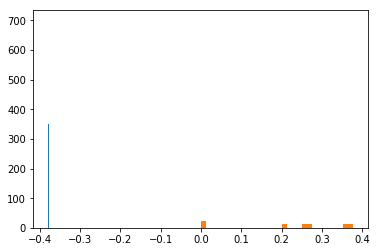

C:\Users\Robert Wang\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


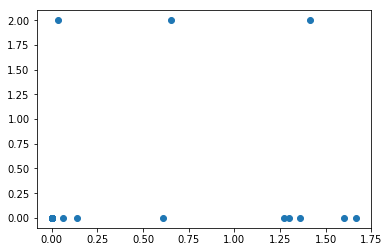

In [856]:
h = 5
sample_size = 20
eigs = []
scores = []
for a in range(sample_size):
    tsamples = simulation([0.05 for i in range(50)], 11, h)
    sub_sample = []
    left_size = 0
    for i in range(2**(h-1)):
        if np.random.random() < 0.5:
            sub_sample.append(i)
            left_size += 1
    for i in range(2**(h-1), 2**h):
        if np.random.random() < 0.1:
            sub_sample.append(i)
    G = construct_similarity_graph(tsamples, subset=sub_sample, threshold=2)
    S, diag = spectral_split(G, return_eig=True)
    left = 0
    right = 0
    for v in S:
        if v < 2**(h-1):
            left += 1
        else:
            right += 1
    eigs.append(diag[0][1])
    wrong = min(left, right)
    scores.append(wrong)
    if wrong > 0 and diag[0][1] < 0.1:
        v2 = diag[1][:,1]
        plt.hist(v2[:left], density=True, bins=30)
        plt.hist(v2[left:], density=True, bins=30)
        plt.show()
plt.plot(eigs, scores, marker='o', ls='none')
    

lambda_2 (0.4731249781843017+0j)
1024 1024


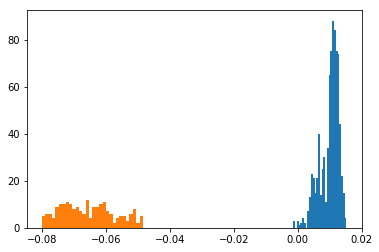

lambda_2 (0.509057927837689+0j)
1058 1058


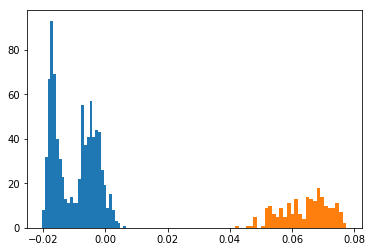

lambda_2 (0.4815951693960723+0j)
1030 1030


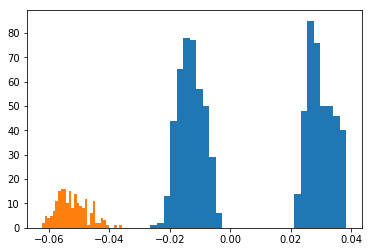

lambda_2 (0.5628569334317911+0j)
1027 1027


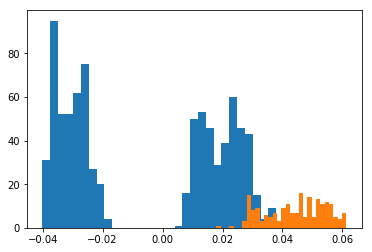

lambda_2 (0.41869050304743244+0j)
1048 1048


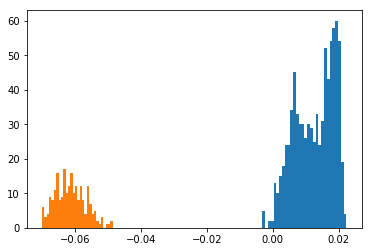

In [953]:
h = 12
for a in range(5):
    tsamples = simulation([0.1 for i in range(40)], 11, h)
    sub_sample = []
    left_size = 0
    for i in range(2**(h-1)):
        if np.random.random() < 0.4:
            sub_sample.append(i)
            left_size += 1
    for i in range(2**(h-1), 2**h):
        if np.random.random() < 0.1:
            sub_sample.append(i)
    G = construct_similarity_graph(tsamples, subset=sub_sample)
    L = nx.normalized_laplacian_matrix(G).todense()
    diag = sp.linalg.eig(L)
    print('lambda_2', diag[0][1])
    v2 = diag[1][:,1]
    x = {}
    vertices = list(G.nodes())
    print(len(vertices), len(v2))
    for i in range(len(vertices)):
        x[vertices[i]] = v2[i]
    plt.hist(v2[:left_size], bins=30)
    plt.hist(v2[left_size:], bins=30)
    plt.show()

lambda_2 (0.6066237833521159+0j)


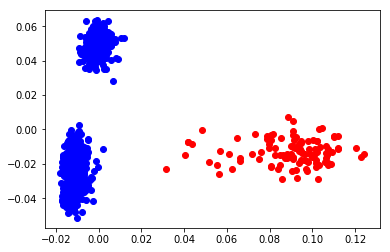

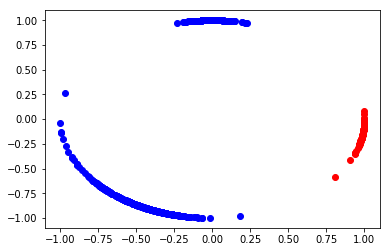

lambda_2 (0.43772880261072744+0j)


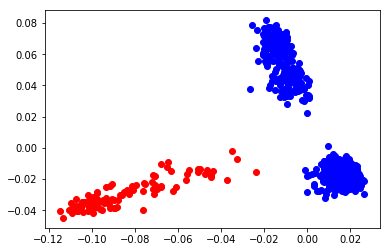

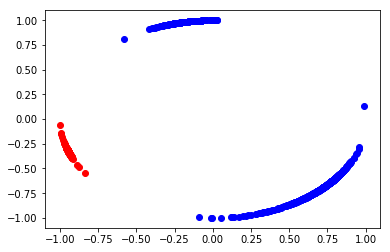

lambda_2 (0.4588838324421098+0j)


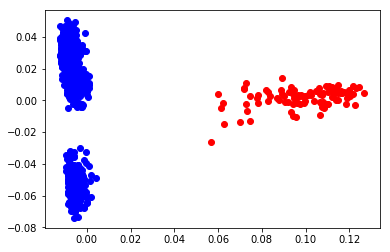

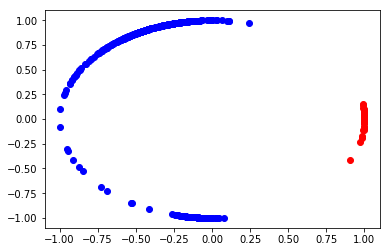

lambda_2 (0.4450144121393202+0j)


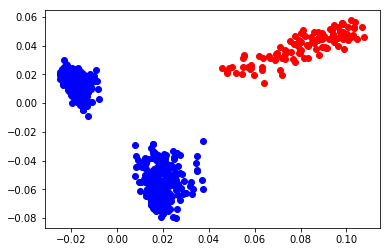

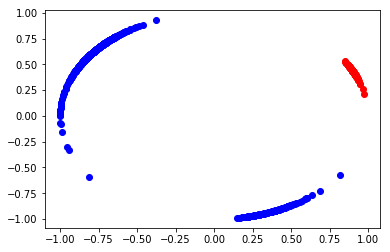

lambda_2 (0.5303900912314443+0j)


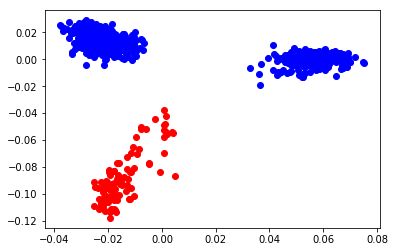

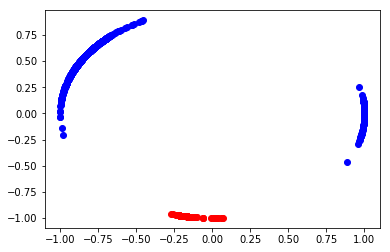

lambda_2 (0.42428966242897787+0j)


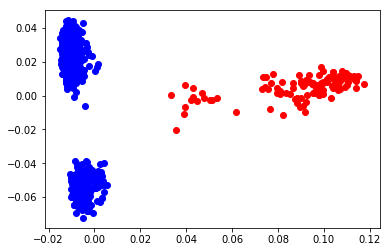

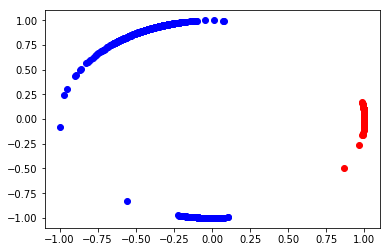

In [956]:
h = 12
for a in range(6):
    E = Experiment([0.05 for i in range(100)], 11, h, dropout_rate=0.2)
    sub_sample = biased_sampling(len(E.samples), 0.2, lambda x: x**2)
    left_size = sum([1 for i in range(2**(h-1)) if i in sub_sample])
    G = construct_similarity_graph(E.samples, subset=sub_sample)
    L = nx.normalized_laplacian_matrix(G).todense()
    diag = sp.linalg.eig(L)
    print('lambda_2', diag[0][1])
    v2 = diag[1][:,1:3]
    plt.plot(v2[:left_size,0], v2[:left_size,1], marker='o', ls='none', color='red')
    plt.plot(v2[left_size:,0], v2[left_size:,1], marker='o', ls='none', color='blue')
    plt.show()
    for i in range(len(v2)):
        denom = np.linalg.norm(v2[i,:])
        v2[i][0] = v2[i][0]/denom
        v2[i][1] = v2[i][1]/denom
    x = {}
    vertices = list(G.nodes())
    for i in range(len(vertices)):
        x[vertices[i]] = v2[i]
    plt.plot(v2[:left_size,0], v2[:left_size,1], marker='o', ls='none', color='red')
    plt.plot(v2[left_size:,0], v2[left_size:,1], marker='o', ls='none', color='blue')
    plt.show()

{1, 2, 3}

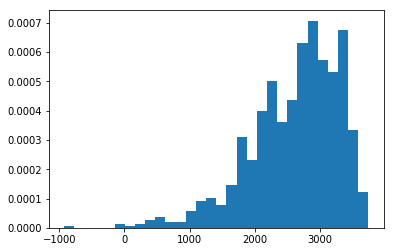

In [339]:
h = 8
E = Experiment([0.05 for i in range(100)], 11, h, dropout_rate=0)
G = construct_connectivity_graph(E.samples)
weights = []
for j in range(1000):
    u = np.random.choice(2**(h-1), 1)[0]
    v = np.random.choice(list(range(2**(h-1), 2**h)), 1)[0]
    if (u,v) in G.edges():
        weights.append(G[u][v]['weight'])
plt.hist(weights, density=True, bins=30)  # `density=False` would make counts
plt.show()

In [335]:
(76,244) in G.edges()

True

In [818]:
def biased_sampling(n, proportion, f=lambda x: x):
    denom = sum([f(i) for i in range (n)])
    sampled = []
    for i in range(n):
        if np.random.random() < proportion*n*f(i)/denom:
            sampled.append(i)
    return sampled

In [811]:
print(biased_sampling(100, 0.2, lambda x: x**2))

0.18
[53, 55, 57, 72, 78, 80, 81, 83, 84, 87, 88, 89, 91, 93, 94, 95, 96, 97]


In [815]:
def TC_levels(sample_size=10, h=10, sample_rate =0.2, bias_function=lambda x: 1, num_char=200, p=0.05, num_states=21, dr=0, thresh=0):
    depths = [d for d in range(int(h/2)+2)]
    tc_mxc = []
    tc_g = []
    tc_gi = []
    for a in range(sample_size):
        print('experiment', a)
        E = Experiment([p for i in range(num_char)], num_states, h, dropout_rate=dr)
        subsample = biased_sampling(len(E.samples), sample_rate, bias_function)
        Tm = E.build_tree('spectral', subset=subsample, sim_thresh=thresh)
        Tg = E.build_tree('greedy', subset=subsample)
        Tgi = E.build_tree('sgreedy+', subset=subsample, sim_thresh=thresh)
        tc_mxc.append(E.triplets_correct_at_depth(Tm, method='all', sampling_depths=depths))
        tc_g.append(E.triplets_correct_at_depth(Tg, method='all', sampling_depths=depths))
        tc_gi.append(E.triplets_correct_at_depth(Tgi, method='all', sampling_depths=depths))
    print([arr[0] for arr in tc_mxc])
    plt.errorbar(depths, np.average(tc_mxc, axis=0), yerr=np.std(tc_mxc, axis=0)/np.sqrt(sample_size), marker='o', markersize='5', color='black', label='spectral')
    plt.errorbar(depths, np.average(tc_g, axis=0), yerr=np.std(tc_g, axis=0)/np.sqrt(sample_size), marker='o', markersize='5', color='red', label='greedy')
    plt.errorbar(depths, np.average(tc_gi, axis=0), yerr=np.std(tc_gi, axis=0)/np.sqrt(sample_size), marker='o', markersize='5', color='blue', label='sgreedy+')
    plt.xlabel("depth")
    plt.ylabel("triplets correct")
    plt.legend()
    plt.show()


experiment 0
experiment 1
experiment 2
experiment 3
experiment 4
experiment 5
experiment 6
experiment 7
experiment 8
experiment 9
[1.0, 0.637, 0.62, 1.0, 0.656, 0.608, 0.601, 0.621, 1.0, 0.607]


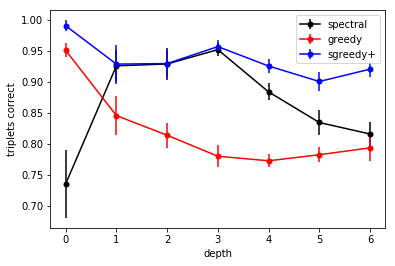

experiment 0
experiment 1
experiment 2
experiment 3
experiment 4
experiment 5
experiment 6
experiment 7
experiment 8
experiment 9
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


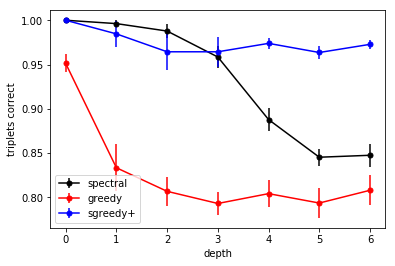

experiment 0
experiment 1
experiment 2
experiment 3
experiment 4
experiment 5
experiment 6
experiment 7
experiment 8
experiment 9
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


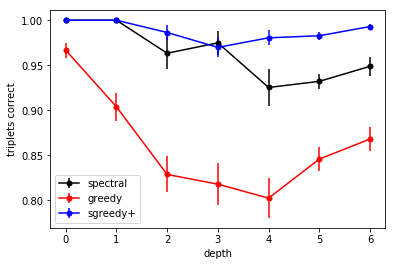

In [824]:
TC_levels(sample_rate=0.2, bias_function=lambda x: x, num_char=40, p=0.1, num_states=11, thresh=1)
TC_levels(sample_rate=0.2, bias_function=lambda x: x, num_char=100, p=0.05, num_states=11, thresh=2)
TC_levels(sample_rate=0.2, bias_function=lambda x: x, num_char=200, p=0.05, num_states=21, thresh=2)

experiment 0
experiment 1
experiment 2
experiment 3
experiment 4
experiment 5
experiment 6
experiment 7
experiment 8
experiment 9
[0.973, 0.551, 0.58, 0.627, 0.577, 1.0, 0.507, 0.579, 0.935, 1.0]


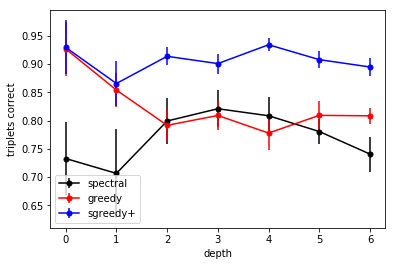

experiment 0
experiment 1
experiment 2
experiment 3
experiment 4
experiment 5
experiment 6
experiment 7
experiment 8
experiment 9
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.971, 0.596, 1.0, 1.0]


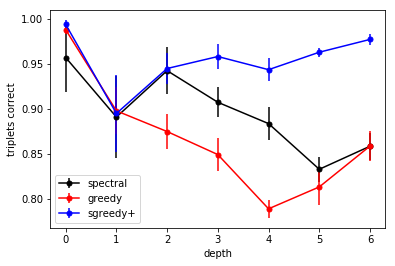

experiment 0
experiment 1
experiment 2
experiment 3
experiment 4
experiment 5
experiment 6
experiment 7
experiment 8
experiment 9
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


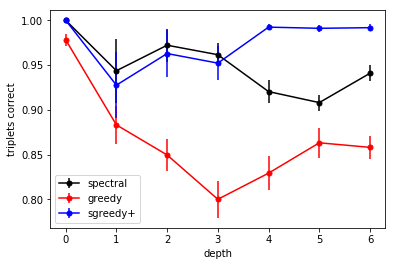

In [832]:
TC_levels(sample_rate=0.2, bias_function=lambda x: x**2, num_char=40, p=0.1, num_states=11, thresh=1)
TC_levels(sample_rate=0.2, bias_function=lambda x: x**2, num_char=100, p=0.05, num_states=11, thresh=2)
TC_levels(sample_rate=0.2, bias_function=lambda x: x**2, num_char=200, p=0.05, num_states=21, thresh=2)

experiment 0


C:\Users\Robert Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


experiment 1
experiment 2
experiment 3
experiment 4
experiment 5
experiment 6
experiment 7
experiment 8
experiment 9


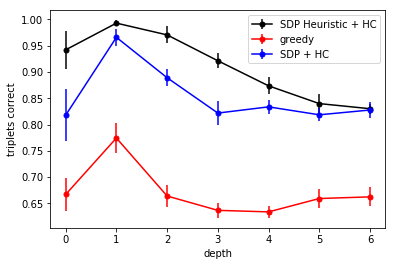

In [291]:
TC_levels(num_states=4)

experiment 0


C:\Users\Robert Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


experiment 1
experiment 2
experiment 3
experiment 4
experiment 5
experiment 6
experiment 7
experiment 8
experiment 9


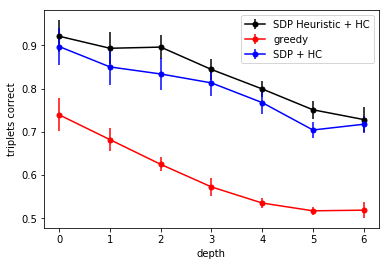

In [292]:
TC_levels(num_states=4, dr=0.2)

In [701]:
def test_ps(lst, sample_size=5, h=10, sample_rate=0.2, num_char=40, num_states=11, dr=0):
    print("testing p vals")
    data = np.zeros((3, len(lst), sample_size))
    pos = 0
    for p in lst:
        for i in range(sample_size):
            E = Experiment([p for i in range(num_char)], num_states, h, dropout_rate=dr)
            subsample = set()
            for j in range(len(E.samples)):
                if np.random.random() < sample_rate:
                    subsample.add(j)
            Tm = E.build_tree('spectral', subset=subsample)
            Tg = E.build_tree('greedy', subset=subsample)
            Tgi = E.build_tree('sgreedy+', subset=subsample)
            data[0,pos,i] = E.triplets_correct(Tm)
            data[1,pos,i] = E.triplets_correct(Tg)
            data[2,pos,i] = E.triplets_correct(Tgi)
            print("pos = ", pos, "sample number", i)
        pos += 1
    mu_mxc = [np.average(data[0, pos, :]) for pos in range(len(lst))]
    std_mxc = [np.std(data[0, pos, :])/np.sqrt(sample_size) for pos in range(len(lst))]
    mu_g = [np.average(data[1, pos, :]) for pos in range(len(lst))]
    std_g = [np.std(data[1, pos, :])/np.sqrt(sample_size) for pos in range(len(lst))]
    mu_gi = [np.average(data[2, pos, :]) for pos in range(len(lst))]
    std_gi = [np.std(data[2, pos, :])/np.sqrt(sample_size) for pos in range(len(lst))]

    plt.errorbar(lst, mu_mxc, yerr=std_mxc, marker='o', markersize='5', color='black', label='spectral')
    plt.errorbar(lst, mu_g, yerr=std_g, marker='o', markersize='5',  color='red', label='greedy ')
    plt.errorbar(lst, mu_gi, yerr=std_gi, marker='o', markersize='5', color='blue', label='greedy+ hill climb')
    plt.xlabel("character mutation probability")
    plt.ylabel("triplets correct")
    plt.legend()
    plt.show()

def test_nc(lst, sample_size=5, h=10, sample_rate=0.2, p=0.1, num_states=11, dr=0):
    print("testing number of chars")
    data = np.zeros((3, len(lst), sample_size))
    pos = 0
    for num_char in lst:
        for i in range(sample_size):
            E = Experiment([p for i in range(num_char)], num_states, h, dropout_rate=dr)
            subsample = set()
            for j in range(len(E.samples)):
                if np.random.random() < sample_rate:
                    subsample.add(j)
            Tm = E.build_tree('spectral', subset=subsample)
            Tg = E.build_tree('greedy', subset=subsample)
            Tgi = E.build_tree('sgreedy+', subset=subsample)
            data[0,pos,i] = E.triplets_correct(Tm)
            data[1,pos,i] = E.triplets_correct(Tg)
            data[2,pos,i] = E.triplets_correct(Tgi)
            print("pos = ", pos, "sample number", i)
        pos += 1
    mu_mxc = [np.average(data[0, pos, :]) for pos in range(len(lst))]
    std_mxc = [np.std(data[0, pos, :])/np.sqrt(sample_size) for pos in range(len(lst))]
    mu_g = [np.average(data[1, pos, :]) for pos in range(len(lst))]
    std_g = [np.std(data[1, pos, :])/np.sqrt(sample_size) for pos in range(len(lst))]
    mu_gi = [np.average(data[2, pos, :]) for pos in range(len(lst))]
    std_gi = [np.std(data[2, pos, :])/np.sqrt(sample_size) for pos in range(len(lst))]

    plt.errorbar(lst, mu_mxc, yerr=std_mxc, marker='o', markersize='5', color='black', label='spectral')
    plt.errorbar(lst, mu_g, yerr=std_g, marker='o', markersize='5',  color='red', label='greedy ')
    plt.errorbar(lst, mu_gi, yerr=std_gi, marker='o', markersize='5', color='blue', label='greedy+ hill climb')
    plt.xlabel("number of characters")
    plt.ylabel("triplets correct")
    plt.legend()
    plt.show()

def test_drop_out(lst, sample_size=5, h=10, sample_rate=0.2, num_char=40, p=0.1, num_states=11):
    print("testing dropout")
    data = np.zeros((3, len(lst), sample_size))
    pos = 0
    for dr in lst:
        for i in range(sample_size):
            E = Experiment([p for i in range(num_char)], num_states, h, dropout_rate=dr)
            subsample = set()
            for j in range(len(E.samples)):
                if np.random.random() < sample_rate:
                    subsample.add(j)
            Tm = E.build_tree('spectral', subset=subsample)
            Tg = E.build_tree('greedy', subset=subsample)
            Tgi = E.build_tree('sgreedy+', subset=subsample)
            data[0,pos,i] = E.triplets_correct(Tm)
            data[1,pos,i] = E.triplets_correct(Tg)
            data[2,pos,i] = E.triplets_correct(Tgi)
            print("pos = ", pos, "sample number", i)
        pos += 1
    mu_mxc = [np.average(data[0, pos, :]) for pos in range(len(lst))]
    std_mxc = [np.std(data[0, pos, :])/np.sqrt(sample_size) for pos in range(len(lst))]
    mu_g = [np.average(data[1, pos, :]) for pos in range(len(lst))]
    std_g = [np.std(data[1, pos, :])/np.sqrt(sample_size) for pos in range(len(lst))]
    mu_gi = [np.average(data[2, pos, :]) for pos in range(len(lst))]
    std_gi = [np.std(data[2, pos, :])/np.sqrt(sample_size) for pos in range(len(lst))]

    plt.errorbar(lst, mu_mxc, yerr=std_mxc, marker='o', markersize='5', color='black', label='spectral')
    plt.errorbar(lst, mu_g, yerr=std_g, marker='o', markersize='5',  color='red', label='greedy ')
    plt.errorbar(lst, mu_gi, yerr=std_gi, marker='o', markersize='5', color='blue', label='greedy+ hill climb')
    plt.xlabel("drop_out_rate")
    plt.ylabel("triplets correct")
    plt.legend()
    plt.show()
    
def test_qs(lst, sample_size=5, h=10, sample_rate=0.2, num_char=40, p=0.1, dr=0):
    print("testing number of states")
    data = np.zeros((3, len(lst), sample_size))
    pos = 0
    for num_states in lst:
        for i in range(sample_size):
            E = Experiment([p for i in range(num_char)], num_states, h, dropout_rate=dr)
            subsample = set()
            for j in range(len(E.samples)):
                if np.random.random() < sample_rate:
                    subsample.add(j)
            Tm = E.build_tree('SDP', subset=subsample)
            Tg = E.build_tree('greedy', subset=subsample)
            Tgi = E.build_tree('greedy+', subset=subsample)
            data[0,pos,i] = E.triplets_correct(Tm)
            data[1,pos,i] = E.triplets_correct(Tg)
            data[2,pos,i] = E.triplets_correct(Tgi)
            #print("pos = ", pos, "sample number", i)
        pos += 1
    mu_mxc = [np.average(data[0, pos, :]) for pos in range(len(lst))]
    std_mxc = [np.std(data[0, pos, :])/np.sqrt(sample_size) for pos in range(len(lst))]
    mu_g = [np.average(data[1, pos, :]) for pos in range(len(lst))]
    std_g = [np.std(data[1, pos, :])/np.sqrt(sample_size) for pos in range(len(lst))]
    mu_gi = [np.average(data[2, pos, :]) for pos in range(len(lst))]
    std_gi = [np.std(data[2, pos, :])/np.sqrt(sample_size) for pos in range(len(lst))]

    plt.errorbar(lst, mu_mxc, yerr=std_mxc, marker='o', markersize='5', color='black', label='SDP-MXC')
    plt.errorbar(lst, mu_g, yerr=std_g, marker='o', markersize='5',  color='red', label='greedy ')
    plt.errorbar(lst, mu_gi, yerr=std_gi, marker='o', markersize='5', color='blue', label='greedy+ hill climb')
    plt.xlabel("number of states")
    plt.ylabel("triplets correct")
    plt.title("p = " + str(p))
    plt.legend()
    plt.show()


testing number of chars
pos =  0 sample number 0
pos =  0 sample number 1
pos =  0 sample number 2
pos =  0 sample number 3
pos =  0 sample number 4
pos =  0 sample number 5
pos =  0 sample number 6
pos =  0 sample number 7
pos =  0 sample number 8
pos =  0 sample number 9
pos =  1 sample number 0
pos =  1 sample number 1
pos =  1 sample number 2
pos =  1 sample number 3
pos =  1 sample number 4
pos =  1 sample number 5
pos =  1 sample number 6
pos =  1 sample number 7
pos =  1 sample number 8
pos =  1 sample number 9
pos =  2 sample number 0
pos =  2 sample number 1
pos =  2 sample number 2
pos =  2 sample number 3
pos =  2 sample number 4
pos =  2 sample number 5
pos =  2 sample number 6
pos =  2 sample number 7
pos =  2 sample number 8
pos =  2 sample number 9
pos =  3 sample number 0
pos =  3 sample number 1
pos =  3 sample number 2
pos =  3 sample number 3
pos =  3 sample number 4
pos =  3 sample number 5
pos =  3 sample number 6
pos =  3 sample number 7
pos =  3 sample number 8
p

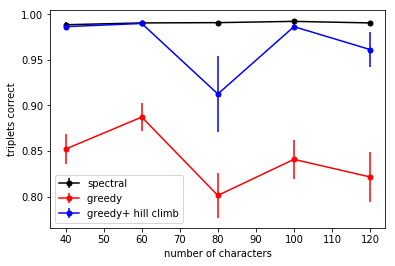

In [756]:
test_nc([40,60,80,100,120], sample_size=10, num_states=11, h=10, dr=0.2)

testing number of chars
pos =  0 sample number 0
pos =  0 sample number 1
pos =  0 sample number 2
pos =  0 sample number 3
pos =  0 sample number 4
pos =  0 sample number 5
pos =  0 sample number 6
pos =  0 sample number 7
pos =  0 sample number 8
pos =  0 sample number 9
pos =  1 sample number 0
pos =  1 sample number 1
pos =  1 sample number 2
pos =  1 sample number 3
pos =  1 sample number 4
pos =  1 sample number 5
pos =  1 sample number 6
pos =  1 sample number 7
pos =  1 sample number 8
pos =  1 sample number 9
pos =  2 sample number 0
pos =  2 sample number 1
pos =  2 sample number 2
pos =  2 sample number 3
pos =  2 sample number 4
pos =  2 sample number 5
pos =  2 sample number 6
pos =  2 sample number 7
pos =  2 sample number 8
pos =  2 sample number 9
pos =  3 sample number 0
pos =  3 sample number 1
pos =  3 sample number 2
pos =  3 sample number 3
pos =  3 sample number 4
pos =  3 sample number 5
pos =  3 sample number 6
pos =  3 sample number 7
pos =  3 sample number 8
p

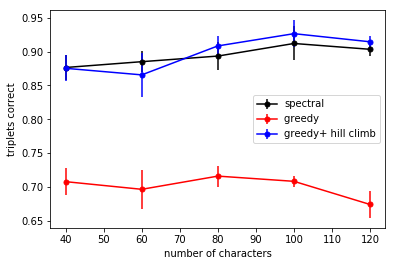

In [757]:
test_nc([40,60,80,100,120], sample_size=10, num_states=4, h=10, dr=0.2)

testing dropout
pos =  0 sample number 0
pos =  0 sample number 1
pos =  0 sample number 2
pos =  0 sample number 3
pos =  0 sample number 4
pos =  0 sample number 5
pos =  0 sample number 6
pos =  0 sample number 7
pos =  0 sample number 8
pos =  0 sample number 9
pos =  1 sample number 0
pos =  1 sample number 1
pos =  1 sample number 2
pos =  1 sample number 3
pos =  1 sample number 4
pos =  1 sample number 5
pos =  1 sample number 6
pos =  1 sample number 7
pos =  1 sample number 8
pos =  1 sample number 9
pos =  2 sample number 0
pos =  2 sample number 1
pos =  2 sample number 2
pos =  2 sample number 3
pos =  2 sample number 4
pos =  2 sample number 5
pos =  2 sample number 6
pos =  2 sample number 7
pos =  2 sample number 8
pos =  2 sample number 9
pos =  3 sample number 0
pos =  3 sample number 1
pos =  3 sample number 2
pos =  3 sample number 3
pos =  3 sample number 4
pos =  3 sample number 5
pos =  3 sample number 6
pos =  3 sample number 7
pos =  3 sample number 8
pos =  3 

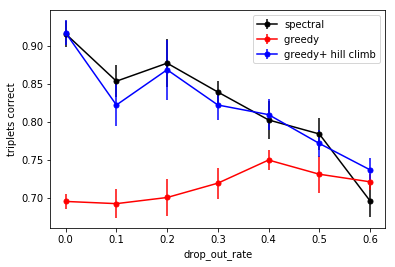

In [758]:
test_drop_out([0,0.1,0.2,0.3,0.4,0.5,0.6], sample_size=10, num_states=4, h=10)

testing dropout
pos =  0 sample number 0
pos =  0 sample number 1
pos =  0 sample number 2
pos =  0 sample number 3
pos =  0 sample number 4
pos =  0 sample number 5
pos =  0 sample number 6
pos =  0 sample number 7
pos =  0 sample number 8
pos =  0 sample number 9
pos =  1 sample number 0
pos =  1 sample number 1
pos =  1 sample number 2
pos =  1 sample number 3
pos =  1 sample number 4
pos =  1 sample number 5
pos =  1 sample number 6
pos =  1 sample number 7
pos =  1 sample number 8
pos =  1 sample number 9
pos =  2 sample number 0
pos =  2 sample number 1
pos =  2 sample number 2
pos =  2 sample number 3
pos =  2 sample number 4
pos =  2 sample number 5
pos =  2 sample number 6
pos =  2 sample number 7
pos =  2 sample number 8
pos =  2 sample number 9
pos =  3 sample number 0
pos =  3 sample number 1
pos =  3 sample number 2
pos =  3 sample number 3
pos =  3 sample number 4
pos =  3 sample number 5
pos =  3 sample number 6
pos =  3 sample number 7
pos =  3 sample number 8
pos =  3 

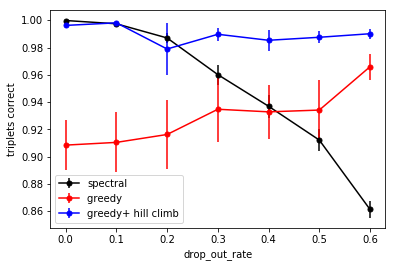

In [759]:
test_drop_out([0,0.1,0.2,0.3,0.4,0.5,0.6], sample_size=10, num_char=200, p=0.05, num_states=21, h=10)

In [27]:
ps = [0.05,0.1,0.15,0.2,0.25]
ns = [2, 6, 11, 16, 21]

testing number of states


C:\Users\Robert Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


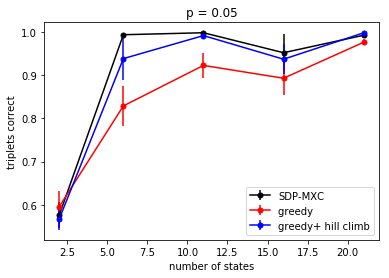

testing number of states


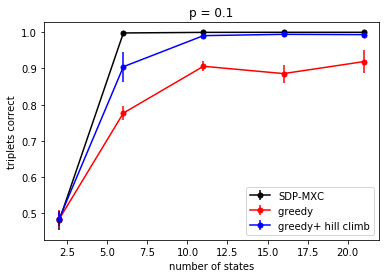

testing number of states


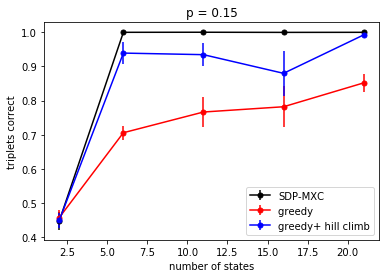

testing number of states


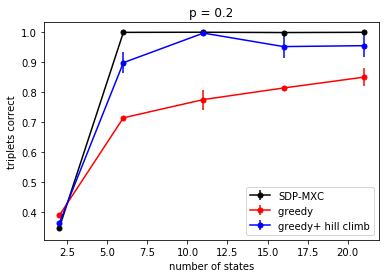

testing number of states


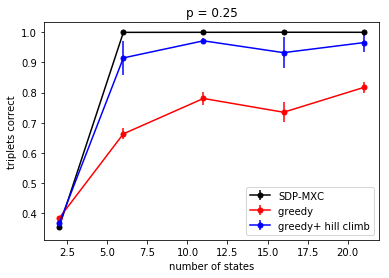

In [35]:
for prob in ps:
    test_qs(ns, h=10, p=prob)

In [50]:
'''
num_experiments = 10
h = 9
sample_rate = 0.2
dr = 0.2
experiments = []
MXC_cut_scores = np.zeros(num_experiments)
MXC_TC = np.zeros((3, num_experiments), dtype=float)
G_cut_scores = np.zeros(num_experiments)
G_TC = np.zeros((3, num_experiments), dtype=float)
GI_cut_scores = np.zeros(num_experiments)
GI_TC = np.zeros((3, num_experiments), dtype=float)

def get_cut_data(G, B, superset, S, T, cut_scores, TC_scores, i):
    cut_score = evaluate_cut(G,B,S)
    s = ''
    s += "cut score = " + str(cut_score) + " "
    cut_scores[i] = cut_score
    TC, TI, UR = evaluate_split(superset, S, T)
    TC_scores[0][i], TC_scores[1][i], TC_scores[2][i] = TC, TI, UR
    s += "triplets correct = " + str(TC) + " "
    s += "triplets incorrect = " + str(TI) + " "
    s += "unresolved = "+ str(UR)
    return s

for index in range(num_experiments):
    E = Experiment([0.1 for i in range(40)], 11, h, dropout_rate=dr)
    experiments.append(E)
    subsample = []
    for i in range(len(E.samples)):
        if np.random.random() < sample_rate:
            subsample.append(i)
    G = construct_connectivity_graph(E.samples, subset=subsample)
    MX_cut = max_cut_heuristic(G,3,50)
    g_cut = greedy_cut(E.samples, subset=subsample)
    gI_cut = improve_cut(G, g_cut.copy())
    print("new sample")
    print("max cut")
    print(get_cut_data(G, B, subsample, MX_cut, E.ground_truth_tree, MXC_cut_scores, MXC_TC, index))
    print("greedy cut")
    print(get_cut_data(G, B, subsample, g_cut, E.ground_truth_tree, G_cut_scores, G_TC, index))
    print("greedy + hill climb cut")
    print(get_cut_data(G, B, subsample, gI_cut, E.ground_truth_tree, GI_cut_scores, GI_TC, index))
#print(MXC_TC)
-------------------------------------------

'''
def num_chars_expr(char_nums, h=10, sample_rate=0.2, num_trials=5):
    num_experiments = len(char_nums)
    MXC_cut_scores = np.zeros(num_experiments)
    MXC_TC = np.zeros((3, num_experiments), dtype=float)
    G_cut_scores = np.zeros(num_experiments)
    G_TC = np.zeros((3, num_experiments), dtype=float)
    GI_cut_scores = np.zeros(num_experiments)
    GI_TC = np.zeros((3, num_experiments), dtype=float)

    for ind in range(len(char_nums)):
        cm = char_nums[ind]
        for trial in range(num_trials):
            E = Experiment([0.1 for i in range(cm)], 4, h)
            experiments.append(E)
            subsample = []
            for jay in range(len(E.samples)):
                if np.random.random() < sample_rate:
                    subsample.append(jay)
            G = construct_connectivity_graph(E.samples, subset=subsample)
            MX_cut = max_cut_heuristic(G,3,50)
            g_cut = greedy_cut(E.samples, subset=subsample)
            gI_cut = improve_cut(G, g_cut.copy())
            MXC_cut_scores[ind] += evaluate_cut(MX_cut, G)
            G_cut_scores[ind] += evaluate_cut(g_cut,G)
            GI_cut_scores[ind] += evaluate_cut(gI_cut,G)
            T = E.ground_truth_tree
            TC, TI, UR = evaluate_split(subsample, MX_cut, T)
            MXC_TC[0][ind] += TC
            MXC_TC[1][ind] += TI
            MXC_TC[2][ind] += UR
            TC, TI, UR = evaluate_split(subsample, g_cut, T)
            G_TC[0][ind] += TC
            G_TC[1][ind] += TI
            G_TC[2][ind] += UR
            TC, TI, UR = evaluate_split(subsample, gI_cut, T)
            GI_TC[0][ind] += TC
            GI_TC[1][ind] += TI
            GI_TC[2][ind] += UR
            print("trial " + str(trial) + " of experiment " + str(ind))
    MXC_cut_scores = MXC_cut_scores/num_trials
    MXC_TC = MXC_TC/num_trials
    G_cut_scores = G_cut_scores/num_trials
    G_TC = G_TC/num_trials
    GI_cut_scores = GI_cut_scores/num_trials
    GI_TC = GI_TC/num_trials
    
    f1 = plt.figure()
    plt.plot(char_nums, MXC_cut_scores,  marker='o', markersize='5', color='black', label='SDP Heuristic + HC')
    plt.plot(char_nums, G_cut_scores, ls='none', marker='o', markersize='5', color='red', label='Greedy')
    plt.plot(char_nums, GI_cut_scores, ls='none',  marker='o', markersize='5', color='blue', label='Greedy+HC')
    plt.ylabel("cut scores of splitting algorithms")
    plt.xlabel("number of characters")
    plt.show()
    plt.savefig("mxc.pdf")
    plt.plot(char_nums, MXC_TC[0,:], marker='o', markersize='5', color='black', label='SDP Heuristic + HC')
    plt.plot(char_nums, G_TC[0,:], ls='none', marker='o', markersize='5', color='red', label='Greedy')
    plt.plot(char_nums, GI_TC[0,:],  ls='none', marker='o', markersize='5', color='blue', label='Greedy+HC')
    plt.ylabel("proportions of triplets correct")
    plt.xlabel("number of characters")
    plt.legend()
    plt.show()
    plt.plot(char_nums, MXC_TC[1,:],  marker='o', markersize='5', color='black', label='SDP Heuristic + HC')
    plt.plot(char_nums, G_TC[1,:], ls='none',  marker='o', markersize='5', color='red', label='Greedy')
    plt.plot(char_nums, GI_TC[1,:], ls='none', marker='o', markersize='5', color='blue', label='Greedy+HC')
    plt.ylabel("proportions of triplets incorrect")
    plt.xlabel("number of characters")
    plt.legend()
    plt.show()
    plt.plot(char_nums, MXC_TC[2,:],  marker='o', markersize='5', color='black', label='SDP Heuristic + HC')
    plt.plot(char_nums, G_TC[2,:], ls='none', marker='o', markersize='5', color='red', label='Greedy')
    plt.plot(char_nums, GI_TC[2,:], ls='none', marker='o', markersize='5', color='blue', label='Greedy+HC')
    plt.ylabel("proportions of triplets unresolved")
    plt.xlabel("number of characters")
    plt.legend()
    plt.show()
    
#num_chars_expr([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], h=10, sample_rate=0.1, num_trials=5)

In [52]:
def compare_trees(num_experiments=10, h=10, sample_rate=0.2, p=0.1, num_char=20, num_states=4, dr=0):
    for i in range(num_experiments):
        E = Experiment([p for i in range(num_char)], num_states, h, dropout_rate=dr)
        subsample = set()
        for j in range(len(E.samples)):
            if np.random.random() < sample_rate:
                subsample.add(j)
        Tm = E.build_tree('SDP', subset=subsample)
        Tg = E.build_tree('greedy', subset=subsample)
        Tgi = E.build_tree('greedy+', subset=subsample)
        print("SDP TC: ", E.triplets_correct(Tm), " greedy TC:", E.triplets_correct(Tg), " greedy hill-climb TC:", E.triplets_correct(Tgi))

#compare_trees(10, h=10, sample_rate=0.2, p=0.1, num_char=20, num_states=4, dr=0)

In [56]:
'''
remove duplicates tests



n1 = Node([1,0,3], 5)
n2 = Node([0,3,3], 5)
n3 = Node([4,1,3], 5)
n4 = Node([4,2,3], 5)
n5 = Node([1,0,4], 5)
n6 = Node([0,3,0], 5)
n7 = Node([2,1,0], 5)
n8 = Node([2,2,2], 5)
nodes = [n1,n2,n2,n4,n1,n1,n4,n4,n1,n1,n5,n5]
indices = [0,1,2,3,6,8,9,10,11]

for i in indices:
    print(nodes[i])
remove_duplicates(nodes, indices)
-----------------------
node tests

n1 = Node([0,-1,1,4], 5)
n2 = Node([0,2,0,4], 4)
n3 = Node([2,2,0,4], 4)
n4 = Node([2,2,1,4], 4)
tsamples = [n1,n2,n3,n4]
Gt, Bt = construct_connectivity_graph(tsamples, subset={0,2,3})
print(nx.adjacency_matrix(Gt).todense())
print("\n")
print(nx.adjacency_matrix(Bt).todense())
'''
pass

In [14]:
{1,2,3}.copy()

{1, 2, 3}

In [37]:
start_time = time.time()
lst = [n for n in range(1000)]
for i in range(1000000):
    if lst[0] == lst[0]:
        z = "reeee"
    if lst[0] == lst[1]-1:
        z = "reeee"
    if lst[1]-1 == lst[0]:
        z = "reeee" 
    if lst[1]-1 == lst[0]:
        z = "reeee" 
print( (time.time() - start_time))

0.45979928970336914


In [1]:
def build_tree_sep(samples, method='greedy', subset = None, sim_thresh=0):
    if not subset:
        subset = list(range(len(samples)))
    else:
        subset = list(subset)
    subset = remove_duplicates(samples, subset)
    T = nx.DiGraph()
    for i in subset:
        T.add_node(i)
    def build_helper(S):
        assert S, "error, S = "+ str(S)
        if len(S) == 1:
            return list(S)[0]
        left_set = set()
        if method == 'greedy':
            left_set = greedy_cut(samples, subset=S)
        elif method == 'SDP':
            G = construct_connectivity_graph(samples, subset=S)
            left_set = max_cut_heuristic(G, 3, 50)
        elif method == 'greedy+':
            G = construct_connectivity_graph(samples, subset=S)
            left_set = greedy_cut(samples, subset=S)
            left_set = improve_cut(G,left_set)
        elif method == 'spectral':
            G = construct_similarity_graph(samples, subset=list(S), threshold=sim_thresh)
            left_set = spectral_split(G)
            left_set = spectral_improve_cut(left_set, G)
        elif method == 'sgreedy+':
            G = construct_similarity_graph(samples, subset=S, threshold=sim_thresh)
            left_set = spectral_improve_cut(greedy_cut(samples, subset=S) , G)

        if len(left_set) == 0 or len(left_set) == len(S):
            left_set = greedy_cut(samples, subset=S)
        right_set = set()
        for i in S:
            if not i in left_set:
                right_set.add(i)
        root = len(T.nodes) - len(subset) + len(samples)
        T.add_node(root)
        left_child = build_helper(left_set)
        right_child = build_helper(right_set)
        T.add_edge(root, left_child)
        T.add_edge(root, right_child)
        return root
    build_helper(subset)
    return T

In [11]:
def triplets_correct_sep(T, Tt, sample_size=5000):
    TC = 0
    sample_set = np.array([v for v in T.nodes() if T.in_degree(v) == 1 and T.out_degree(v) == 0])
    for a in range(sample_size):
        chosen = np.random.choice(sample_set, 3, replace=False)
        if outgroup2(chosen[0], chosen[1], chosen[2], T)[0] == outgroup2(chosen[0], chosen[1], chosen[2], Tt)[0]:
            TC += 1
    return TC/sample_size

def outgroup2(i, j, k, T):
    assert i != j and i != k and j != k, str(i) + ' ' + str(j) + ' ' + str(k) + ' not distinct'
    
#     Li = find_tree_lineage(i, T)
#     Lj = find_tree_lineage(j, T)
#     Lk = find_tree_lineage(k, T)

    Li = [node for node in nx.ancestors(T, i)]
    Lj = [node for node in nx.ancestors(T, j)]
    Lk = [node for node in nx.ancestors(T, k)]
    
    ij_common = len(set(Li) & set(Lj))
    ik_common = len(set(Li) & set(Lk))
    jk_common = len(set(Lj) & set(Lk))
    index = min(ij_common, ik_common, jk_common)

    if ij_common == ik_common and ik_common == jk_common:
        return None, index
    if ij_common > ik_common and ij_common > jk_common:
        return k, index
    elif jk_common > ik_common and jk_common > ij_common:
        return i, index
    elif ik_common > ij_common and ik_common > jk_common:
        return j, index

from collections import defaultdict
def triplets_correct_stratified(T, Tt, sample_size=5000, min_size_depth = 20):
    correct_class = defaultdict(int)
    freqs = defaultdict(int)
    sample_set = np.array([v for v in T.nodes() if T.in_degree(v) == 1 and T.out_degree(v) == 0])
    
    for a in range(sample_size):
        chosen = np.random.choice(sample_set, 3, replace=False)
        out1, index = outgroup2(chosen[0], chosen[1], chosen[2], T)
        out2, index2 = outgroup2(chosen[0], chosen[1], chosen[2], Tt)
        correct_class[index] += (out1 == out2)
        freqs[index] += 1
        
    tot_tp = 0
    num_consid = 0
    
    for k in correct_class.keys():
        if freqs[k] > min_size_depth:

            num_consid += 1
            tot_tp += correct_class[k] / freqs[k]

    tot_tp /= num_consid
    return tot_tp

In [12]:
def get_colless(network):
    root = [n for n in network if network.in_degree(n) == 0][0]
    colless = [0]
    colless_helper(network, root, colless)
    n = len([n for n in network if network.out_degree(n) == 0 and network.in_degree(n) == 1]) 
    return colless[0], (colless[0] - n * np.log(n) - n * (np.euler_gamma - 1 - np.log(2)))/n

def colless_helper(network, node, colless):
    if network.out_degree(node) == 0:
        return 1
    else:
        leaves = []
        for i in network.successors(node):
            leaves.append(colless_helper(network, i, colless))
        colless[0] += abs(leaves[0] - leaves[1])
        return sum(leaves)

In [13]:
def triplets_correct_at_time_sep(T, Tt, method='all', bin_size = 10, sample_size=5000, sampling_depths=None):
    sample_set = set([v for v in T.nodes() if T.in_degree(v) == 1 and T.out_degree(v) == 0])
    children = {}
    num_triplets = {}
    nodes_at_depth = {}

    def find_children(node, total_time):
        t = total_time + Tt.nodes[node]['parent_lifespan']
        children[node] = []
        if Tt.out_degree(node) == 0:
            if node in sample_set:
                children[node].append(node)
            return

        for n in Tt.neighbors(node):
            find_children(n, t)
            children[node] += children[n]

        L, R = list(Tt.neighbors(node))[0], list(Tt.neighbors(node))[1]
        num_triplets[node] = len(children[L])*nCr(len(children[R]), 2) + len(children[R])*nCr(len(children[L]), 2)
        if num_triplets[node] > 0:
            bin_num = t//bin_size
            
            if bin_num in nodes_at_depth:
                nodes_at_depth[bin_num].append(node)
            else:
                nodes_at_depth[bin_num] = [node]
                
    root = [n for n in Tt if Tt.in_degree(n) == 0][0]
    find_children(root, 0)

    def sample_at_depth(d):
        denom = sum([num_triplets[v] for v in nodes_at_depth[d]])
        node = np.random.choice(nodes_at_depth[d], 1, [num_triplets[v]/denom for v in nodes_at_depth[d]])[0]
        L, R = list(Tt.neighbors(node))[0], list(Tt.neighbors(node))[1]
        if np.random.random() < (len(children[R])-1)/(len(children[R])+len(children[L])-2):
            outgrp = np.random.choice(children[L], 1)[0]
            ingrp = np.random.choice(children[R], 2, replace=False)
        else:
            outgrp = np.random.choice(children[R], 1)[0]
            ingrp = np.random.choice(children[L], 2, replace=False)
        return outgroup(ingrp[0], ingrp[1], outgrp, T) == outgrp

    if not sampling_depths:
        sampling_depths = [d for d in range(len(nodes_at_depth))]
    if method == 'aggregate':
        score = 0
        freq = 0
        for d in sampling_depths:
            if d in nodes_at_depth:
                max_children = 0
                for i in nodes_at_depth[d]:
                    if len(children[i]) > max_children:
                        max_children = len(children[i])
                if max_children > 10:
                    freq += 1
                    for a in range(sample_size):
                        score += int(sample_at_depth(d))
        return score/(sample_size*freq)
    elif method == 'all':
        ret = ['NA'] * len(sampling_depths)
        for d in sampling_depths:
            if d in nodes_at_depth:
                max_children = 0
                for i in nodes_at_depth[d]:
                    if len(children[i]) > max_children:
                        max_children = len(children[i])
                if max_children > 10:
                    score = 0
                    for a in range(sample_size):
                        score += int(sample_at_depth(d))
                    ret[d] = score/sample_size
        return np.array(ret)

In [15]:
def triplets_correct_at_depth_sep(T, Tt, method='all', sample_size=5000, sampling_depths=None):
    sample_set = set([v for v in T.nodes() if T.in_degree(v) == 1 and T.out_degree(v) == 0])
    children = {}
    num_triplets = {}
    nodes_at_depth = {}

    def find_children(node, depth):
        children[node] = []
        if Tt.out_degree(node) == 0:
            if node in sample_set:
                children[node].append(node)
            return

        for n in Tt.neighbors(node):
            find_children(n, depth+1)
            children[node] += children[n]

        L, R = list(Tt.neighbors(node))[0], list(Tt.neighbors(node))[1]
        num_triplets[node] = len(children[L])*nCr(len(children[R]), 2) + len(children[R])*nCr(len(children[L]), 2)
        if num_triplets[node] > 0:
            if depth in nodes_at_depth:
                nodes_at_depth[depth].append(node)
            else:
                nodes_at_depth[depth] = [node]
                
    root = [n for n in Tt if Tt.in_degree(n) == 0][0]
    find_children(root, 0)

    def sample_at_depth(d):
        denom = sum([num_triplets[v] for v in nodes_at_depth[d]])
        node = np.random.choice(nodes_at_depth[d], 1, [num_triplets[v]/denom for v in nodes_at_depth[d]])[0]
        L, R = list(Tt.neighbors(node))[0], list(Tt.neighbors(node))[1]
        if np.random.random() < (len(children[R])-1)/(len(children[R])+len(children[L])-2):
            outgrp = np.random.choice(children[L], 1)[0]
            ingrp = np.random.choice(children[R], 2, replace=False)
        else:
            outgrp = np.random.choice(children[R], 1)[0]
            ingrp = np.random.choice(children[L], 2, replace=False)
        return outgroup(ingrp[0], ingrp[1], outgrp, T) == outgrp

    if not sampling_depths:
        sampling_depths = [d for d in range(len(nodes_at_depth))]
        
    if method == 'aggregate':
        score = 0
        freq = 0
        for d in sampling_depths:
            if d in nodes_at_depth:
                max_children = 0
                for i in nodes_at_depth[d]:
                    if len(children[i]) > max_children:
                        max_children = len(children[i])
                if max_children > 10:
                    freq += 1
                    for a in range(sample_size):
                        score += int(sample_at_depth(d))
        return score/(sample_size*freq)
    elif method == 'all':
        ret = ['NA'] * len(sampling_depths)
        for d in sampling_depths:
            if d in nodes_at_depth:
                max_children = 0
                for i in nodes_at_depth[d]:
                    if len(children[i]) > max_children:
                        max_children = len(children[i])
                if max_children > 10:
                    score = 0
                    for a in range(sample_size):
                        score += int(sample_at_depth(d))
                    ret[d] = score/sample_size
        return np.array(ret) 

In [14]:
for folder in ["400cells_base_higher_herit"]:
#     folder = "400cells_" + drop + "_drop"
    path = "/data/yosef2/users/richardz/projects/benchmarking/" + folder + "/"
    nums = []
    triplets = []
    triplets_new = []
    colless = []
    types = []
    methods = []

    for method in ["greedy", "sgreedy+", "spectral"]:
        for num in range(0, 10):
            dropout_cm = pd.read_csv(path + "dropout_cm" + str(num) + ".txt", sep = '\t', index_col = 0)
            dropout_cm = dropout_cm.applymap(str)

            samples = []
            for index, row in dropout_cm.iterrows():
                node = Node(list(row), 1001, parent=None, left=None, right=None)
                samples.append(node)

            subset = list(range(len(samples)))
            prune_samples = remove_duplicates(samples, subset)

            node_map = {}
            for i in prune_samples:
                node_map[i] = list(dropout_cm.iloc[i,:])

            net = pic.load(open(path + "dropout_net" + str(num) + ".pkl", 'rb'))
            ground = net.network
            leaves = [n for n in ground if ground.out_degree(n) == 0 and ground.in_degree(n) == 1]
            ground_net_map = {}
            for i in node_map:
                for j in leaves:
                    if node_map[i] == j.char_vec:
                        ground_net_map[j] = i
                        break
            ground = nx.relabel_nodes(ground, ground_net_map)

            dropout_cm = dropout_cm.replace("-", -1)
            dropout_cm = dropout_cm.replace("*", -1)
            dropout_cm = dropout_cm.apply(pd.to_numeric)

            samples = []
            for index, row in dropout_cm.iterrows():
                node = Node(list(row), 1001, parent=None, left=None, right=None)
                samples.append(node)
        #     sample_map = {}
        #     for i in range(len(samples)):
        #         sample_map[i] = samples[i]
            recon = build_tree_sep(samples, method=method)
            trip = triplets_correct_stratified(recon, ground)
            trip2 = triplets_correct_at_time_sep(recon, ground, 'aggregate')
            print(num, trip, trip2, method)
            triplets.append(trip)
            triplets_new.append(trip2)
            nums.append(num)
            colless.append(get_colless(ground)[0])
            types.append(folder)
            methods.append(method)

    data = [nums, triplets, triplets_new, colless, methods, types]
    df = pd.DataFrame(data)
    df = df.T
    df = df.rename(columns = {0: 'Run', 1: 'TripletsCorrect', 2: 'TripletsCorrect2', 3:'Colless', 4:'Method',5: 'Type'})
#     df.to_csv(path + 'methods_triplets.txt', sep = '\t', index = False)

0 0.8064134615064897 0.8042 greedy


KeyboardInterrupt: 